In [1]:
import os

In [2]:
%pwd

'/home/fmlpc/Shashank/Course_Work/MLOPS/MLOPS_Project_Skin_Cancer_Detection/research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'/home/fmlpc/Shashank/Course_Work/MLOPS/MLOPS_Project_Skin_Cancer_Detection'

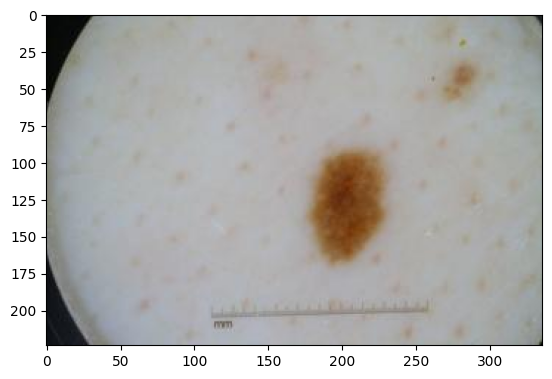

In [7]:
img_path = "/home/fmlpc/Shashank/Course_Work/MLOPS/MLOPS_Project_Skin_Cancer_Detection/artifacts/data_ingestion/ISIC_2019_Training_Input_preprocessed/ISIC_0012653_downsampled.jpg"
import matplotlib.pyplot as plt
from PIL import Image
im = Image.open(img_path)
plt.imshow(im)


In [9]:
import numpy as np

np.array(im).shape

(224, 336, 3)

In [31]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class PrepareBaseModelConfig:
    root_dir: Path
    base_model_path: Path
    pretrained: bool
    params_image_size: list
    params_learning_rate: float
    params_arch_name: str
    params_classes: int


# @dataclass(frozen=True)
# class PrepareBaseModelConfig:
#     root_dir: Path
#     base_model_path: Path
#     updated_base_model_path: Path
#     params_image_size: list
#     params_learning_rate: float
#     params_include_top: bool
#     params_weights: str
#     params_classes: int


# @dataclass(frozen=True)
# class PrepareBaseModelConfig:
#     root_dir: Path
#     pretrained: bool
#     params_image_size: list
#     params_learning_rate: float
#     params_arch_name: str
#     params_classes: int

In [32]:
from Skin_Cancer_Classifier.constants import CONFIG_FILE_PATH, PARAMS_FILE_PATH
from Skin_Cancer_Classifier.utils.common import read_yaml, create_directories


In [33]:
class ConfigurationManager:
    def __init__(self, config_filepath=CONFIG_FILE_PATH, params_filepath=PARAMS_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)

        create_directories([self.config.artifacts_root])

    def get_prepare_base_model_config(self) -> PrepareBaseModelConfig:
        config = self.config.prepare_base_model

        root_dir = Path(config.root_dir)
        arch_name = self.params.ARCH_NAME
        base_model_path = root_dir / f"model_{arch_name}.pth"

        prepare_base_model_config = PrepareBaseModelConfig(
                                root_dir=root_dir,
                                base_model_path=base_model_path,
                                pretrained=self.params.PRETRAINED,
                                params_image_size=self.params.IMAGE_SIZE,
                                params_learning_rate=self.params.LEARNING_RATE,
                                params_arch_name = arch_name,
                                params_classes=self.params.CLASSES)
        
        return prepare_base_model_config
    
    def get_training_config(self) -> TrainingConfig:
        

In [34]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
from efficientnet_pytorch import EfficientNet
print(torch.__version__)

1.13.1+cu117


In [28]:
# class PrepareBaseModel:
#     def __init__(self, config: PrepareBaseModelConfig):
#         self.config = config

#     def get_base_model(self):
#         self.model = Baseline(pretrained=self.config.pretrained, arch_name=self.config.params_arch_name, num_classes=self.config.params_classes)

#         self.save_model(path=self.config.base_model_path, model=self.model)
    
#     @staticmethod
#     def save_model(path: Path, model: torchvision.model)


class PrepareBaseModel:
    def __init__(self, config: PrepareBaseModelConfig):
        self.config = config

    def get_base_model(self):
        self.model = Baseline(
            pretrained=self.config.pretrained,
            arch_name=self.config.params_arch_name,
            num_classes=self.config.params_classes
        )
        self.save_model(path=self.config.base_model_path, model=self.model)
    
    @staticmethod
    def save_model(path: Path, model: nn.Module):
        """
        Save the PyTorch model to the specified path
        
        Args:
            path: Path where the model should be saved
            model: PyTorch model to be saved
        """
        try:
            # Create parent directories if they don't exist
            path.parent.mkdir(parents=True, exist_ok=True)
            
            # Save the model state dict
            torch.save(model.state_dict(), path)
            print(f"Model saved successfully at: {path}")
        except Exception as e:
            print(f"Error saving model: {e}")
            raise



class Baseline(nn.Module):
    def __init__(self, pretrained=True, arch_name="efficientnet", num_classes=8):
        super(Baseline, self).__init__()

        self.arch_name = arch_name.lower()
        self.num_classes = num_classes

        if self.arch_name == "efficientnet":
            self.base_model = EfficientNet.from_pretrained('efficientnet-b0') if pretrained else EfficientNet.from_name('efficientnet-b0')
            nftrs = self.base_model._fc.in_features
            self.base_model._fc = nn.Linear(nftrs, self.num_classes)

        elif self.arch_name == "resnet18":
            weights = 'IMAGENET1K_V1' if pretrained else 'DEFAULT'
            self.base_model = resnet18(weights=weights)
            nftrs = self.base_model.fc.in_features
            self.base_model.fc = nn.Linear(nftrs, self.num_classes)

        else:
            raise ValueError(f"Unsupported architecture: {arch_name}")


    def forward(self, image):
        return self.base_model(image)

In [35]:
try:
    config = ConfigurationManager()
    prepare_base_model_config = config.get_prepare_base_model_config()
    prepare_base_model = PrepareBaseModel(config=prepare_base_model_config)
    prepare_base_model.get_base_model()
except Exception as e:
    raise e

[2025-04-07 17:02:19,846: INFO: common: yaml file: config/config.yaml loaded successfully]
[2025-04-07 17:02:19,848: INFO: common: yaml file: params.yaml loaded successfully]
[2025-04-07 17:02:19,849: INFO: common: created directory at: artifacts]
Loaded pretrained weights for efficientnet-b0
Model saved successfully at: artifacts/prepare_base_model/model_efficientnet.pth
